In [45]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain.tools.tavily_search import TavilySearchResults

# from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun

In [ ]:
load_dotenv()
groq_model = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [48]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 6, 'total_tokens': 22, 'completion_time': 0.058181818, 'prompt_time': 0.003515597, 'queue_time': 0.051950183, 'total_time': 0.061697415}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'stop', 'logprobs': None}, id='run-68e5fa0d-549d-44b4-98d2-fd7795cf4c8a-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22})

In [49]:
# search_tool = DuckDuckGoSearchRun()
search_tool = TavilySearchResults()

In [50]:
search_tool.invoke("what is a gdp of india?")

[{'title': 'GDP of India 1987-2029 - Statista',
  'url': 'https://www.statista.com/statistics/263771/gross-domestic-product-gdp-in-india/',
  'content': "Gross domestic product (GDP) in India 2029\n\nThe statistic shows GDP in India from 1987 to 2023, with projections up until 2029. In 2023, GDP in India was at around 3.57 trillion U.S. dollars, and it is expected to reach six trillion by the end of the decade. See figures on\xa0India's economic growth here, and the Russian GDP for comparison. \xa0Historical development of the Indian economy",
  'score': 0.8405867},
 {'title': 'How Is the GDP of India Calculated? - Investopedia',
  'url': 'https://www.investopedia.com/articles/investing/050515/how-gdp-india-calculated.asp',
  'content': "Less romantically, many crops are harvested in February and March. Agriculture remains a significant component of the Indian economy. Starting the new year in April allows time to estimate the income from crop yields.\n\nWhat Was India's GDP in 2023?\n

In [51]:
repl = PythonREPL()
code = """
x = 5
y = x * 2
print(y)
"""

In [52]:
repl.run(code)

'10\n'

In [53]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = (
        f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    )
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [54]:
def make_system_prompt(instruction: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [55]:
make_system_prompt(
    "You can only do research. You are working with a chart generator colleague."
)

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [56]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [57]:
research_agent = create_react_agent(
    groq_model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [58]:
chart_agent = create_react_agent(
    groq_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [59]:
def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:

    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "chart_generator")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )

    return Command(update={"messages": result["messages"]}, goto=goto)

In [60]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:

    result = chart_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )

    return Command(update={"messages": result["messages"]}, goto=goto)

In [ ]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
# 170,050
workflow.add_edge(START, "researcher")
app = workflow.compile()

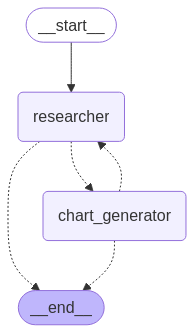

In [62]:
app

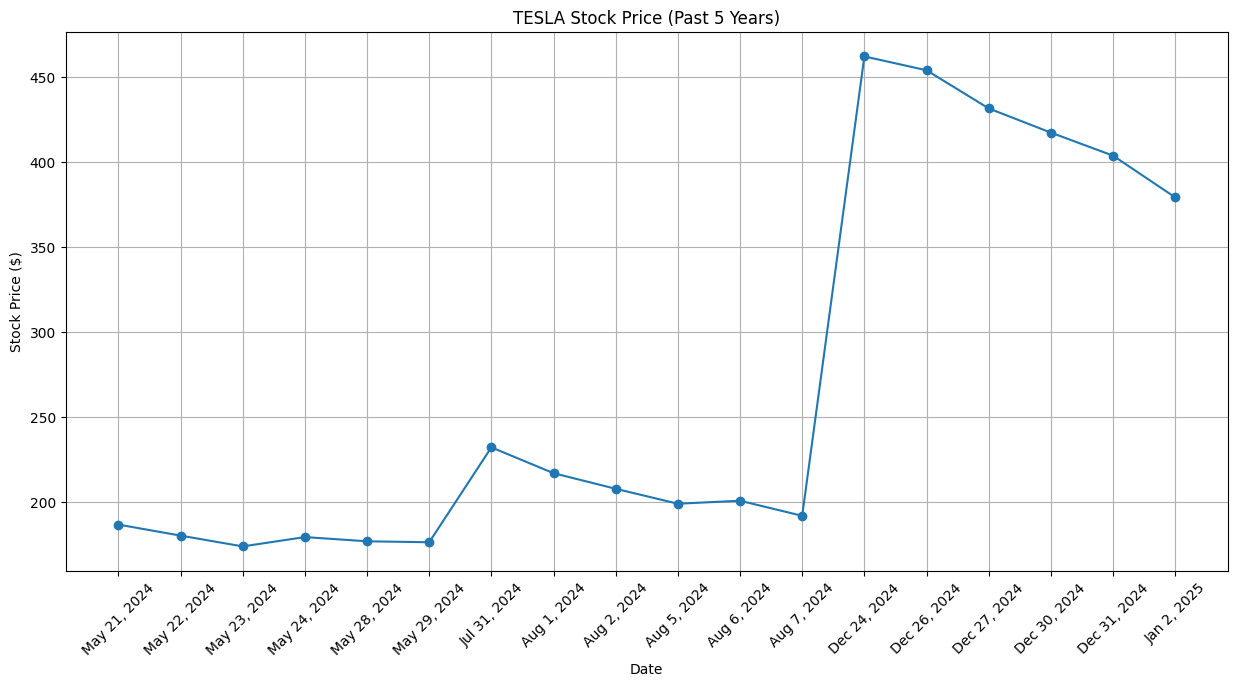

In [64]:
# res = app.invoke({"messages":[("user":"what is the gdp of india over 5 years? then make a line chart if it once you make ")],})
res = app.invoke(
    {
        "messages": [
            (
                "user",
                "get the TESLA over the past 5 years, then make a line chart of it.Once you make the chart, draw it using the pythonrepl.",
            )
        ],
    }
)

In [65]:
res = app.invoke(
    {
        "messages": [
            (
                "user",
                "get the VEDANTA over the past 5 years, then make a line chart of it.Once you make the chart, draw it using the tradingview api.",
            )
        ],
    }
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
res

{'messages': [HumanMessage(content='get the VEDANTA over the past 5 years, then make a line chart of it.Once you make the chart, draw it using the tradingview api.', additional_kwargs={}, response_metadata={}, id='3bac33e8-e66f-4521-b003-0620bcd06196'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r169', 'function': {'arguments': '{"query":"VEDANTA stock price past 5 years"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 366, 'prompt_tokens': 286, 'total_tokens': 652, 'completion_time': 1.330909091, 'prompt_time': 0.040757046, 'queue_time': 1.541737122, 'total_time': 1.371666137}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9fa61f04-1b21-4261-a504-c945970bed39-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'VEDANTA stock price past 5 years'}, 'id': 'call_r169', 'type': 'tool_call'}]

In [ ]:
import yfinance as yf
import json
from IPython.display import HTML, display

# 1. Fetch Data
data = yf.download("VEDL.NS", period="5y")

# 2. Prepare the Data (Corrected for FutureWarning)
prepared_data = []
for index, row in data.iterrows():
    prepared_data.append(
        {
            "time": int(index.timestamp()) * 1000,
            "open": float(row["Open"].iloc[0]),
            "high": float(row["High"].iloc[0]),
            "low": float(row["Low"].iloc[0]),
            "close": float(row["Close"].iloc[0]),
        }
    )

# 3. Set Up the HTML Container and TradingView Script
html_content = f"""
<div style="width:100%; height:600px;">
    <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
    <div id="tv_chart_container" style="width:100%; height:100%;"></div>

    <script type="text/javascript">
    new TradingView.widget({{
        "container_id": "tv_chart_container",
        "symbol": "VEDL",
        "interval": "D",
        "timeframe": "5Y",
        "data": {json.dumps(prepared_data)},
        "theme": "light",
        "autosize": true,
        "locale": "en",
        "style": "1",
        "toolbar_bg": "#f1f3f6",
        "enable_publishing": false,
        "withdateranges": true,
        "allow_symbol_change": true,
        "details": true,
        "calendar": true,
        "studies": [
            "Volume@tv-basicstudies"
        ],
        "show_popup_button": true,
        "popup_width": "900",
        "popup_height": "600",
        "hide_legend": false,
        "hide_side_toolbar":false,
        "hide_top_toolbar":false,
        "hidevolume":false
    }});
    </script>
</div>
"""

# 5. Render the Chart
display(HTML(html_content))

[*********************100%***********************]  1 of 1 completed
